In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from openpathsampling.analysis.tis_analysis import TISTransition
from openpathsampling.analysis.tis_analysis import sampleset_sample_generator

storage = paths.storage.Storage("_toy_retis.nc", mode="r")

In [2]:
print len(storage.samplesets)

201


In [3]:
retis = storage.transitions.load(0)
retis.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.hist_args['max_lambda'] = { 'bin_width' : 0.02, 'bin_range' : (-0.35, 0.35) }

In [4]:
retis.rate(storage)

0.00084341965204695699

In [5]:
%%time
retis.move_summary(storage)
print

pathreversal ran 19.1111111111% of the cycles with acceptance 52/172 (0.302325581395) 
shooting ran 46.2222222222% of the cycles with acceptance 292/416 (0.701923076923) 
minus ran 1.66666666667% of the cycles with acceptance 12/15 (0.8) 
repex ran 21.3333333333% of the cycles with acceptance 156/192 (0.8125) 

CPU times: user 69.2 ms, sys: 3.78 ms, total: 72.9 ms
Wall time: 79.9 ms


In [6]:
%%time
retis.move_summary(storage, 'shooting')
print

OneWayShootingMover I'face 5 ran 7.55555555556% of the cycles with acceptance 40/68 (0.588235294118) 
OneWayShootingMover I'face 4 ran 8.88888888889% of the cycles with acceptance 60/80 (0.75) 
OneWayShootingMover I'face 2 ran 6.66666666667% of the cycles with acceptance 40/60 (0.666666666667) 
OneWayShootingMover I'face 1 ran 7.11111111111% of the cycles with acceptance 52/64 (0.8125) 
OneWayShootingMover I'face 3 ran 8.0% of the cycles with acceptance 32/72 (0.444444444444) 
OneWayShootingMover I'face 0 ran 8.0% of the cycles with acceptance 68/72 (0.944444444444) 

CPU times: user 680 µs, sys: 42 µs, total: 722 µs
Wall time: 728 µs


In [7]:
def first_n(storage, n, trajid):
    sample_iter = sampleset_sample_generator(storage)
    first = []
    old=None
    for s in sample_iter:
        if s.replica == trajid:
            if s != old:
                first.append(s)
            old = s
        if len(first) == n:
            break
    return first

In [8]:
first40 = first_n(storage, 40, trajid=4)

In [9]:
%%time
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

tree = PathTreeBuilder(storage)        
tree.rejected = True
tree.from_samples(first40)
view = tree.renderer
view.zoom = 0.8
view.scale_y = 24
view.scale_x = 14
view.font_size = 0.35

CPU times: user 786 ms, sys: 77.8 ms, total: 864 ms
Wall time: 877 ms


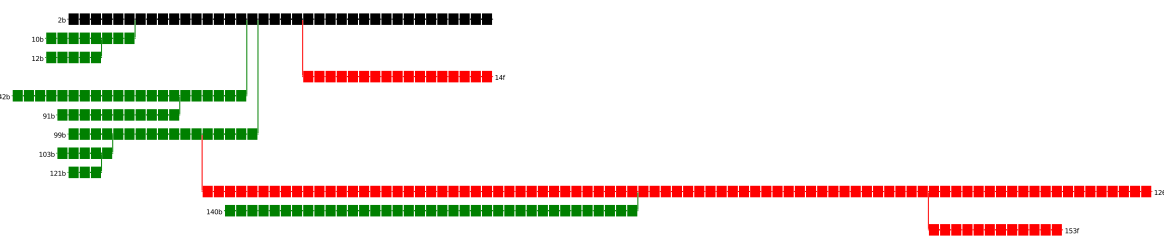

In [10]:
SVG(view.to_svg())

In [11]:
prev = first40[0].trajectory
decorrelated = [prev]
for s in first40:
    if not paths.Trajectory.is_correlated(s.trajectory, prev):
        decorrelated.append(s.trajectory)
        prev = s.trajectory
print "From these samples we have " + str(len(decorrelated)) + " decorrelated trajectories."

From these samples we have 2 decorrelated trajectories.


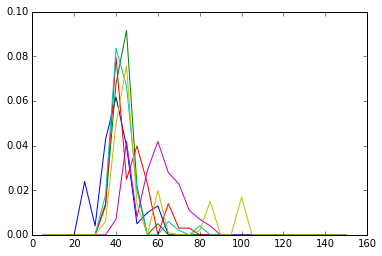

In [12]:
for ens in retis.ensembles:
    myhist = retis.histograms['pathlength'][ens]
    plt.plot(myhist.plot_bins(), myhist.normalized())

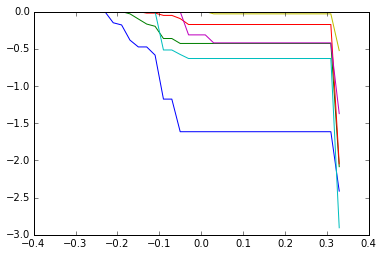

In [13]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), 
             np.log(myhist.reverse_cumulative())
            )

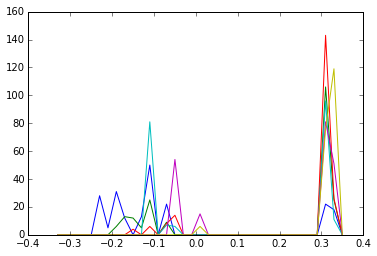

In [14]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), myhist())

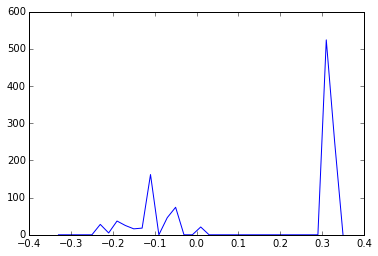

In [15]:
# TODO: add a histogram.sum_hist() function to add several histograms together
from operator import add
total_sampling = np.zeros(len(retis.histograms['max_lambda'][retis.ensembles[0]]()))
for ens in retis.ensembles:
    total_sampling = map(add, total_sampling, retis.histograms['max_lambda'][ens]())
plt.plot(myhist.plot_bins(), total_sampling);

In [16]:
from toy_plot_helpers import ToyPlot
plot = ToyPlot()
plot.add_pes(storage.engines.load(0).pes)

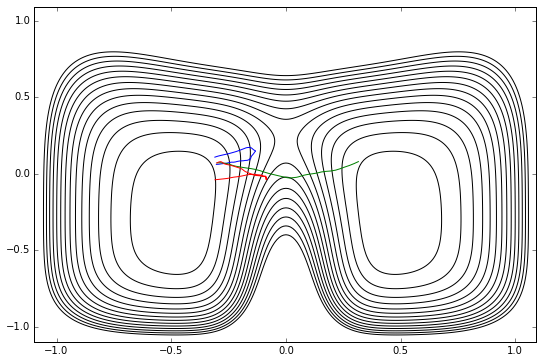

In [17]:
ens0_traj = [s.trajectory for s in storage.samples if s.ensemble == retis.ensembles[0]]
plt.contour(plot.X, plot.Y, plot._pes, levels=np.arange(0.0, 1.5, 0.1), colors='k')
for mytraj in ens0_traj[slice(None,None,15)]:
    plt.plot(mytraj.coordinates()[:,0,0], mytraj.coordinates()[:,0,1])

In [18]:
wham = retis.total_crossing_probability(method="wham")

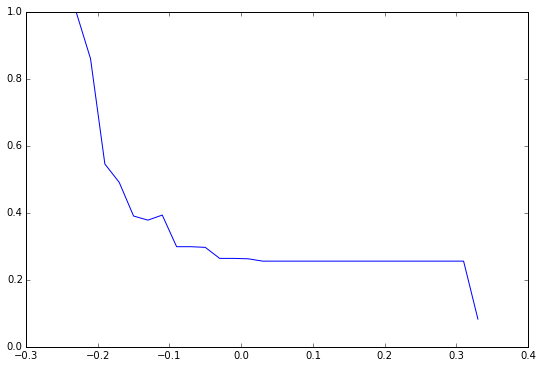

In [19]:
plt.plot(wham.keys(), wham.values());

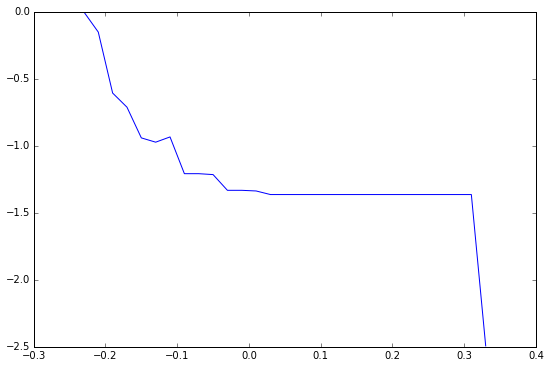

In [20]:
plt.plot(wham.keys(), np.log(wham.values()));

In [21]:
%%time
#retis.rate(storage=storage)
# TODO: conditional_transition_probability, minus_flux, rate
retis.conditional_transition_probability(storage, retis.ensembles[-1])

CPU times: user 207 ms, sys: 17.9 ms, total: 225 ms
Wall time: 256 ms


0.9701492537313433

In [22]:
retis.minus_move_flux(storage)

0.0032921810699588477

In [23]:
print retis._flux, retis.tcp(-0.05), retis.ctp[retis.ensembles[-1]]

0.00329218106996 0.296969239094 0.970149253731


In [24]:
outer_ens = retis.ensembles[-1]

outer_cross_prob = retis.histograms['max_lambda'][outer_ens]
lambda_bin = -1
while (outer_cross_prob.reverse_cumulative()[lambda_bin+1] == 1.0):
    lambda_bin += 1

outer_cross_lambda = outer_cross_prob.bins[lambda_bin]

In [25]:
retis.rate(storage)

0.00084341965204695699